In [20]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os
import sys  
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import json 

# Import modules 
ml_fd_bem_fpath = os.path.join(os.getcwd(), "..", "ml_finite_difference_bem")
if ml_fd_bem_fpath not in sys.path: 
    sys.path.insert(0, ml_fd_bem_fpath)

from ml_finite_difference_bem import simulate, param, result, utils
OpaqueElement, OpaqueMaterial, TransparentMaterial = \
    param.OpaqueElement, param.OpaqueMaterial, param.TransparentMaterial
pp, fd = utils.pp, utils.fd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# ---------------------------------------------------
# Get reference data via configuration file
# ---------------------------------------------------

config_fpath = utils.check_fpath(os.path.join(os.getcwd(), "..", "config.json"))
with open(config_fpath, "r") as fin:
    config_data = json.load(fin)

_root = config_data["optional_root_directory"]
_zipped = zip(config_data["feature_filepath"], 
              config_data["epw_filepath"])
dataset_num = len(config_data["feature_filepath"])
ftdf_arr, ewdf_arr = [None] * dataset_num, [None] * dataset_num
for i, (feat_fpath, epw_fpath) in enumerate(_zipped):
    feat_fpath = utils.check_fpath(os.path.join(_root, feat_fpath))
    epw_fpath = utils.check_fpath(os.path.join(_root, epw_fpath))
    ftdf_arr[i] = result.clean_dataset(pd.read_csv(feat_fpath))
    ewdf_arr[i] = result.get_epw_df(epw_fpath)

In [22]:
# ----------------------------------------
# Define physical constants
# ----------------------------------------

# Construction transmittance (W/m2-K)
wall = OpaqueElement("wall", materials=[OpaqueMaterial("wall_mat")])
wall.materials[0].U = 1.0 / 3.092301818531497
roof = OpaqueElement("roof", materials=[OpaqueMaterial("roof_mat")])
roof.materials[0].U = 1.0 / 3.405501818853292
floor = OpaqueElement("floor")
elements = (wall, floor, roof)

In [15]:
# ----------------------------------------
# Simulate and concatenate results
# ----------------------------------------

# Arrays to collect each feature batch
N = np.sum([ft.shape[0] for ft in ftdf_arr])
fddf_arr = [None] * dataset_num

for i, (ftdf, ewdf) in enumerate(zip(ftdf_arr, ewdf_arr)):
    fddf = result.get_fd_df_2(ftdf.shape[0])
    fd, fddf = simulate.simulate_2(
        elements, ewdf, ftdf, fddf)
    # Concatenate everything to ftdf
    fddf_arr[i] = fddf
    ftdf_arr[i].loc[:, "fd"] = fd
    ftdf_arr[i].loc[:, "ep"] = ftdf.loc[:, "eui"] / 3.6 # kWh/m2

ftdf = pd.concat(ftdf_arr)
ftdf[["fd", "ep"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
fd,3364.0,180.30,10.38,163.95,168.07,181.08,187.13,200.85
ep,3364.0,230.95,12.57,206.17,216.92,232.90,240.77,278.05


In [16]:
# ----------------------------------------
# Solve coefficients for linear regression
# ----------------------------------------

def W_fx(y, X):
    """Closed-form derivation of W = (X^T \cdot X)-1 \cdot X^T \cdot y"""
    
    M = X.shape[1]
    W = X.T @ y  # 2xn @ nx1 = 2x1
    assert np.linalg.det(X.T @ X), 'No determininant. Check multicolinearity.'
    W = np.linalg.pinv(X.T @ X) @ W  # 2x2 @ 2x1 = 2x1
    assert W.shape == (M, 1), pp('W.T:', W.T)
    return W 

GEOM_FEAT_COLS = np.array([         # Correlation w/ fd_bem
    'total_floor_area',             # 0: -0.71
    'envelope_area_to_volume',      # 1:  0.76
    'total_roof_area',              # 2: -0.72 
    'roof_max_height',              # 3: -0.25 
    'footprint_perimeter',          # 4: -0.58
    'east_index',                   # 5: -0.18
    'south_index',                  # 6: -0.09
    'envelope_area_vertical'])      # 7: -0.57
FDBEM_FEAT_COLS = ['fd']            # 8:  1.00

feat_cols_1 = GEOM_FEAT_COLS
feat_cols_2 = np.concatenate((GEOM_FEAT_COLS[[1, 3, 4, 5, 6]], FDBEM_FEAT_COLS))
E = lambda v: np.mean(v)
cov_fx = lambda v1, v2: E((v1 - E(v1)) * (v2 - E(v2)))
rmse_fx = lambda v1, v2: np.sqrt(np.sum((v1 - v2)**2)) / np.sqrt(N)
# Define N,M dimensions for W-matrix
N = ftdf.shape[0]  
M1 = len(feat_cols_1) + 1 
M2 = len(feat_cols_2) + 1 

# W = (X.T X)-1 X.T y; X=data, y=data
# yhat = X @ W  # nx2 @ 2x1 = nx1
y_ = ftdf.ep.to_numpy()[np.newaxis].T  # nx1
X1 = np.vstack([ftdf[c].to_numpy() 
                for c in feat_cols_1] + [np.ones(N)]).T # NxM1
X2 = np.vstack([ftdf[c].to_numpy() 
                for c in feat_cols_2] + [np.ones(N)]).T # NxM2

assert X1.shape == (N, M1)
assert X2.shape == (N, M2)
assert y_.shape == (N, 1)

# Split 20/80 for train/test
train_idx = np.random.choice(N, int(N*0.8), replace=False)
n_mask = [ni in set(train_idx) for ni in np.arange(N)]
test_idx = np.arange(N)[n_mask]
N = test_idx.size

W1 = W_fx(y_[train_idx], X1[train_idx])
W2 = W_fx(y_[train_idx], X2[train_idx])

yh1 = X1[test_idx, :] @ W1  # nx2 @ 2x1 = nx1
yh2 = X2[test_idx, :] @ W2  # nx2 @ 2x1 = nx1
yh1 = yh1.flatten() 
yh2 = yh2.flatten()
y = y_[test_idx, :].flatten()

print("Checking regression coefficients (average change in EUI-rate)")
for i in range(len(feat_cols_2)):
    pp("{}: {}".format(feat_cols_2[i], W2[i, 0].round(4)))

Checking regression coefficients (average change in EUI-rate)
'envelope_area_to_volume: 54.2136'
'roof_max_height: 0.5875'
'footprint_perimeter: 0.0106'
'east_index: 14.4219'
'south_index: 5.9015'
'fd: 1.0471'


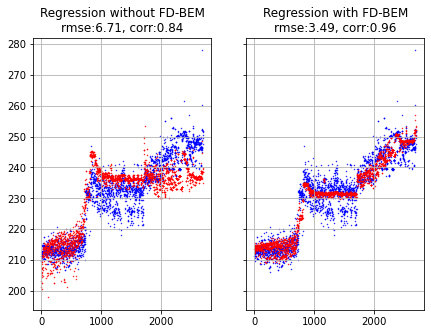

In [17]:
xdata = np.arange(test_idx.size)
sortby_col = 'fd' #'envelope_area_to_volume'
sortby = ftdf[sortby_col].to_numpy()[test_idx] 
idx = np.argsort(sortby)
_, ax = plt.subplots(1,2, figsize=(7,5), sharey=True, sharex=True)

# Error metrics 1
err = y - yh1  # y - yh = e
rmse = np.linalg.norm(err) / np.sqrt(N)
cor = cov_fx(y, yh1) / (np.sqrt(cov_fx(y, y)) * np.sqrt(cov_fx(yh1, yh1)))
ax[0].scatter(xdata, y[idx], s=0.2, c='blue')
ax[0].scatter(xdata, yh1[idx], s=0.2, c='red')
ax[0].set_title("Regression without FD-BEM\nrmse:{}, corr:{}".format(
    rmse.round(2), cor.round(2)));
ax[0].grid(True)
 
# Error metrics 2
err = y - yh2  # y - yh = e
rmse = np.linalg.norm(err) / np.sqrt(N)
cor = cov_fx(y, yh2) / (np.sqrt(cov_fx(y, y)) * np.sqrt(cov_fx(yh2, yh2)))
ax[1].scatter(xdata, y[idx], s=0.2, c='blue')
ax[1].scatter(xdata, yh2[idx], s=0.2, c='red')
ax[1].set_title("Regression with FD-BEM\nrmse:{}, corr:{}".format(
    rmse.round(2), cor.round(2)));
ax[1].grid(True) 

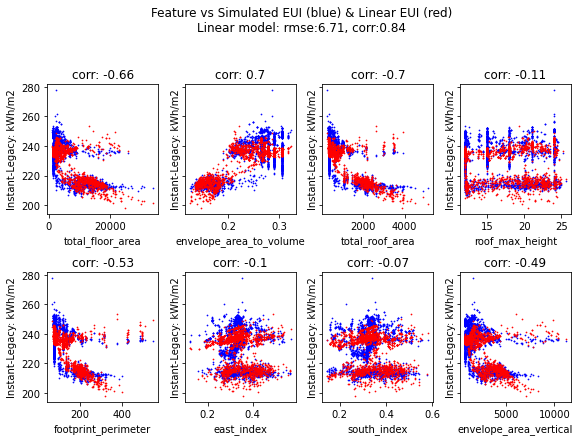

In [18]:
# ----------------------------------------
# Plot linear regression against feats
# ----------------------------------------
y = y_[test_idx, :].flatten()
X = X1[test_idx, :] 
yh = yh1.flatten() 
feat_cols = feat_cols_1 

# Error metrics
err = y - yh  # y - yh = e
rmse = np.linalg.norm(err) / np.sqrt(N)
cor = cov_fx(y, yh) / (np.sqrt(cov_fx(y, y)) * np.sqrt(cov_fx(yh, yh)))
    
fig, ax = plt.subplots(2,4, figsize=(8, 6), sharey=True)
plt.tight_layout(h_pad=5)
ax = [b for a in ax for b in a]
for fi, feat_str in enumerate(feat_cols):
    _y, feat = y, ftdf[feat_str].to_numpy()[test_idx]
    assert _y.shape == feat.shape, (_y.shape, feat.shape)
    cor_ = cov_fx(_y, feat) / (np.sqrt(cov_fx(_y,_y)) * np.sqrt(cov_fx(feat, feat))) 
    ax[fi].set_title('corr: {}'.format(cor_.round(2)))
    ax[fi].scatter(X[:, fi], _y,  s=0.5, c='b');
    ax[fi].scatter(X[:, fi], yh, s=0.5, c='r');
    ax[fi].set_xlabel(feat_str); ax[fi].set_ylabel('Instant-Legacy: kWh/m2');

fig.suptitle("Feature vs Simulated EUI (blue) & Linear EUI (red)\n"
             "Linear model: rmse:{}, corr:{}".format(rmse.round(2), cor.round(2)));
fig.subplots_adjust(top=0.8);

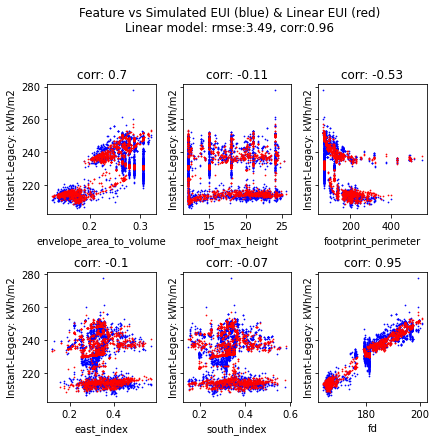

In [19]:
# ----------------------------------------
# Plot linear regression against feats
# ----------------------------------------
y = y_[test_idx, :].flatten()
X = X2[test_idx, :] 
yh = yh2.flatten() 
feat_cols = feat_cols_2

# Error metrics
err = y - yh  # y - yh = e
rmse = np.linalg.norm(err) / np.sqrt(N)
cor = cov_fx(y, yh) / (np.sqrt(cov_fx(y, y)) * np.sqrt(cov_fx(yh, yh)))
    
fig, ax = plt.subplots(2,3,figsize=(6, 6), sharey=True)
plt.tight_layout(h_pad=5)
ax = [b for a in ax for b in a]
for fi, feat_str in enumerate(feat_cols):
    _y, feat = y, ftdf[feat_str].to_numpy()[test_idx]
    assert _y.shape == feat.shape, (_y.shape, feat.shape)
    cor_ = cov_fx(_y, feat) / (np.sqrt(cov_fx(_y,_y)) * np.sqrt(cov_fx(feat, feat))) 
    ax[fi].set_title('corr: {}'.format(cor_.round(2)))
    ax[fi].scatter(X[:, fi], y,  s=0.5, c='b');
    ax[fi].scatter(X[:, fi], yh, s=0.5, c='r');
    ax[fi].set_xlabel(feat_str); ax[fi].set_ylabel('Instant-Legacy: kWh/m2');

fig.suptitle("Feature vs Simulated EUI (blue) & Linear EUI (red)\n"
             "Linear model: rmse:{}, corr:{}".format(rmse.round(2), cor.round(2)));
fig.subplots_adjust(top=0.8);